<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sex          283 non-null    float64
 1   fbs          283 non-null    float64
 2   exang        283 non-null    float64
 3   ca           283 non-null    float64
 4   target       283 non-null    int64  
 5   cp_2.0       283 non-null    int64  
 6   cp_3.0       283 non-null    int64  
 7   cp_4.0       283 non-null    int64  
 8   restecg_1.0  283 non-null    int64  
 9   restecg_2.0  283 non-null    int64  
 10  slope_2.0    283 non-null    int64  
 11  slope_3.0    283 non-null    int64  
 12  thal_6.0     283 non-null    int64  
 13  thal_7.0     283 non-null    int64  
 14  PC1          283 non-null    float64
 15  PC2          283 non-null    float64
 16  PC3          283 non-null    float64
dtypes: float64(7), int64(10)
memory usage: 37.7 KB


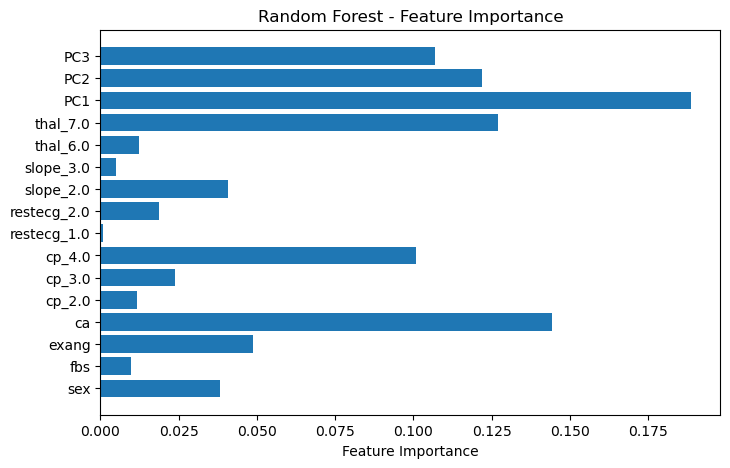

Top 5 Features:
PC1
ca
thal_7.0
PC2
PC3


In [33]:

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

model = RandomForestClassifier()
df=pd.read_csv("../data/pca_heart.csv")
y=df['target']
X=df.drop('target', axis=1)
model.fit(X, y)
# Plot
importances = model.feature_importances_
feat_names = X.columns
df.info()
plt.figure(figsize=(8, 5))
plt.barh(feat_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importance")
plt.show()

# Print top 5 features
top_5 = [(feat_names[i]) for i in importances.argsort()[-5:][::-1]]
print("Top 5 Features:")
for f in top_5:
    print(f)


In [34]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, n_features_to_select=5)  
rfe.fit(X, y)
selectedrfe = X.columns[rfe.support_]
print("Selected Features:", selectedrfe.tolist())

Selected Features: ['sex', 'ca', 'cp_4.0', 'thal_7.0', 'PC1']


In [35]:
from sklearn.feature_selection import SelectKBest, chi2



encoded_features = df.drop(columns=['target', 'PC1', 'PC2', 'PC3'])



y = df['target']


selector = SelectKBest(score_func=chi2, k=5)  
X_new = selector.fit_transform(encoded_features, y)


selected = selector.get_support()
selected_features = encoded_features.columns[selected]
print("Top features by Chi²:", selected_features.tolist())

Top features by Chi²: ['exang', 'ca', 'cp_3.0', 'cp_4.0', 'thal_7.0']


In [36]:

chi2_features = selected_features.tolist()
rfe_features = selectedrfe.tolist()
rf_features = top_5
print(chi2_features,rfe_features,rf_features)
print('#'*1000)
# Convert to sets
chi2_set = set(chi2_features)
rfe_set = set(rfe_features)
rf_set  = set(rf_features)
print (rf_set,chi2_set,rfe_set)
# Find common features
overlap_all = chi2_set & rfe_set & rf_set
overlap_chi_rfe = chi2_set & rfe_set
overlap_chi_rf = chi2_set & rf_set
overlap_rfe_rf = rfe_set & rf_set

# Print results
print("Overlap in all 3 methods:", overlap_all)
print("Chi² ∩ RFE:", overlap_chi_rfe)
print("Chi² ∩ RF:", overlap_chi_rf)
print("RFE ∩ RF:", overlap_rfe_rf)

['exang', 'ca', 'cp_3.0', 'cp_4.0', 'thal_7.0'] ['sex', 'ca', 'cp_4.0', 'thal_7.0', 'PC1'] ['PC1', 'ca', 'thal_7.0', 'PC2', 'PC3']
#####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [37]:
#So we can that the best are 
#best_features = ['exang', 'ca', 'cp_3.0', 'cp_4.0', 'thal_7.0']

In [38]:
##lets do some cross vaildation on the best features
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

feature_sets = {
    'Chi2': chi2_features,
    'RandomForest': rf_features,
    'RFE': rfe_features,
    'otherfeatures':['ca', 'cp_4.0', 'thal_7.0', 'PC1','exang','cp_3.0'],
    'all':X.columns
}

model = RandomForestClassifier(random_state=42)
results = {}

for name, features in feature_sets.items():
    scores = cross_val_score(model, X[features], y, cv=5)
    results[name] = scores
    print(f"{name} mean accuracy: {scores.mean():.3f}")

Chi2 mean accuracy: 0.827
RandomForest mean accuracy: 0.770
RFE mean accuracy: 0.784
otherfeatures mean accuracy: 0.791
all mean accuracy: 0.830


In [39]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Store logistic results
logistic_results = {}

print("\n📊 Logistic Regression Results:")
for name, features in feature_sets.items():
    scores = cross_val_score(logistic_model, X[features], y, cv=5)
    logistic_results[name] = scores
    print(f"{name} mean accuracy: {scores.mean():.3f}")


📊 Logistic Regression Results:
Chi2 mean accuracy: 0.837
RandomForest mean accuracy: 0.820
RFE mean accuracy: 0.848
otherfeatures mean accuracy: 0.837
all mean accuracy: 0.830


In [40]:
from xgboost import XGBClassifier

# Create XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Store XGBoost results
xgb_results = {}

print("\n📊 XGBoost Results:")
for name, features in feature_sets.items():
    scores = cross_val_score(xgb_model, X[features], y, cv=5)
    xgb_results[name] = scores
    print(f"{name} mean accuracy: {scores.mean():.3f}")


📊 XGBoost Results:
Chi2 mean accuracy: 0.830
RandomForest mean accuracy: 0.759
RFE mean accuracy: 0.784
otherfeatures mean accuracy: 0.809
all mean accuracy: 0.827


In [42]:

final_features = ['exang', 'ca', 'cp_3.0', 'cp_4.0', 'thal_7.0']


selected_df = X[final_features].copy()
selected_df['target'] = y  


selected_df.to_csv("../data/selected_features.csv", index=False)
print("✅ Saved to selected_features.csv")

✅ Saved to selected_features.csv
